# Assist-Resist Adaptive Control (ARAC)

Passive & AAN & ARAC experiment 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile

## Experiment

An experiment was conducted on a human subject using CDRR with a resistive band, with ARAC.

### Data Load Old

In [40]:
# file_path = '../data/250516_01.tdms'
# file_path = '../data/250516_05.tdms'

# file_path = '../../data/250602_LJW.tdms'
# split_times = [400, 700] 

# file_path = '../../data/250602_jeongsh.tdms'
# split_times = [350, 750] 

# file_path = '../../data/250605_AJW.tdms'    # AAN 과 ARAC의 차이가 거의 없다. -> 앞으로 ARAC일때는 AAN을 끄고 진행할까 생각중.
# split_times = [300, 700] 

# file_path = '../../data/250605_KDY.tdms'
# split_times = [500, 900] 

# file_path = '../../data/250605_KMJ.tdms'
# split_times = [250, 600] 

# file_path = '../../data/250609_JSH.tdms'
# split_times = [610, 1130] 

### Data Load

In [41]:
file_path = '../../data/250609_LJW.tdms'
split_times = [550, 860]

# file_path = '../../data/250609_JSH.tdms'
# split_times = [550, 930]

# file_path = '../../data/250609_KDH_easy.tdms'
# split_times = [1000, 1350]

# file_path = '../../data/250611_KMJ.tdms'
# split_times = [600, 1000]

# file_path = '../../data/250611_AJW.tdms'
# split_times = [900, 1260]

# file_path = '../../data/250611_PGE.tdms'
# split_times = [410, 790]

# file_path = '../../data/250609_HNG_merged.tdms'
# split_times = [500, 1100]

# file_path = '../../data/250612_AIG.tdms'
# split_times = [410, 810]

tdms = TdmsFile.read(file_path)

print("✅ Available groups and channels:")
group_channel_map = {}
for grp in tdms.groups():
    name = grp.name
    channels = [ch.name for ch in grp.channels()]
    group_channel_map[name] = channels
    print(f" - Group: {name}")
    for ch in channels:
        print(f"    • {ch}")

✅ Available groups and channels:
 - Group: Datas
    • Time (ms)
    • Reference Position X
    • Reference Position Y
    • Measured Position X
    • Measured Position Y
    • Reference Tension L
    • Reference Tension R
    • Reference Tension T
    • Measured Tension L
    • Measured Tension R
    • Measured Tension T
    • RBF1
    • RBF2
    • RBF3
    • RBF4
    • RBF5
    • Trajectory
    • Projected Force
    • Force X
    • Force Y
    • Damp1
    • Damp2
    • Damp3
    • Damp4
    • Damp5
    • Experiment Step


### Raw Data & Split


▶ Using group: Datas


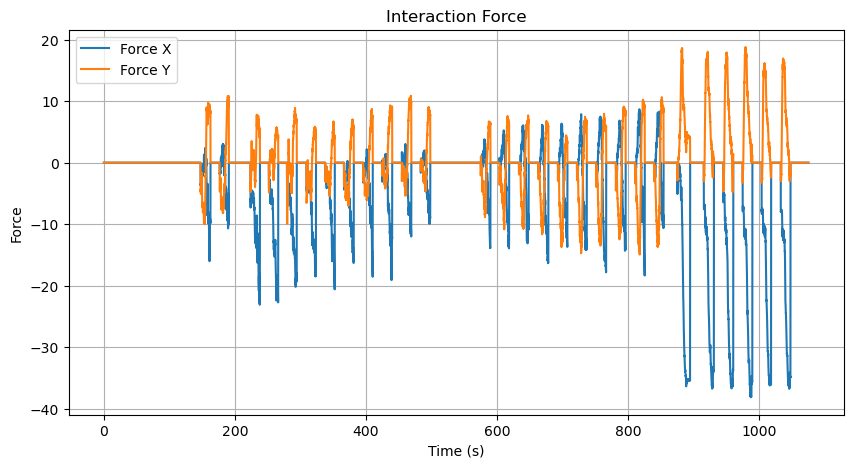

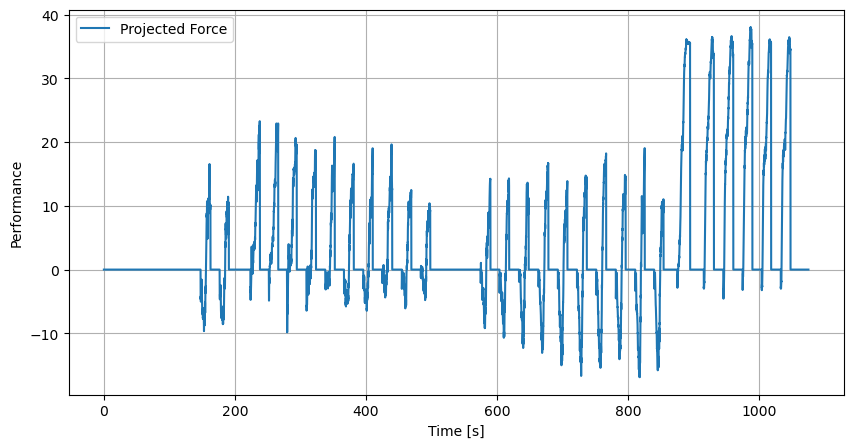

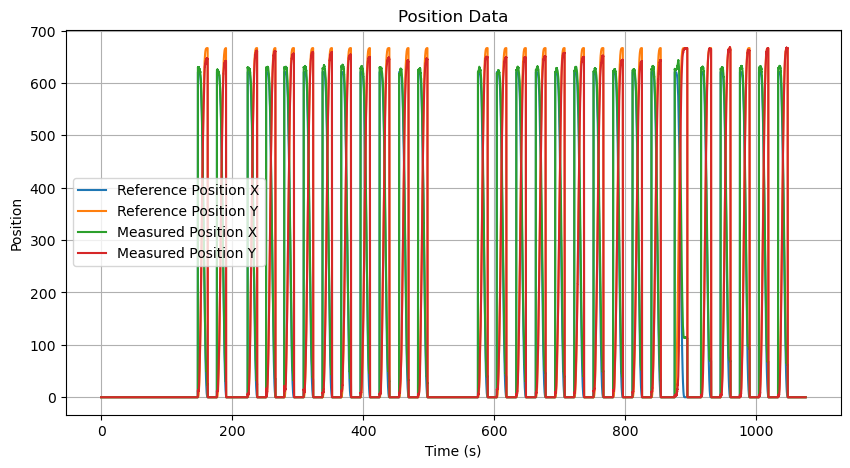

In [42]:
group = 'Datas' if 'Datas' in group_channel_map else list(group_channel_map.keys())[0]
print(f"\n▶ Using group: {group}")

traj = tdms[group]['Trajectory'][:]    # Trajectory 로드
time = np.arange(len(traj)) / 50       # 시간 데이터 생성 (50Hz 가정)

mask = (traj == 1)                     # Traj=1 위치

# Force X, Y 데이터에서 Trajectory가 1인 위치만 필터링
fx = tdms[group]['Force X'][:]
fy = tdms[group]['Force Y'][:]
fx_traj = np.where(mask, fx, 0)
fy_traj = np.where(mask, fy, 0)

plt.figure(figsize=(10,5))
plt.plot(time, fx_traj, color='C0', label='Force X')
plt.plot(time, fy_traj, color='C1', label='Force Y')
plt.title('Interaction Force')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.show()

# Projected Force 데이터 로드
pro_f = tdms[group]['Projected Force'][:]
pro_f_traj = np.where(mask, pro_f, 0)

plt.figure(figsize=(10,5))
plt.plot(time, pro_f_traj, label='Projected Force')
plt.xlabel('Time [s]')
plt.ylabel('Performance')
plt.legend()
plt.grid(True)
plt.show()

# Position 데이터 로드
ref_x = tdms[group]['Reference Position X'][:]
ref_y = tdms[group]['Reference Position Y'][:]
act_x = tdms[group]['Measured Position X'][:]
act_y = tdms[group]['Measured Position Y'][:]
ref_x_traj = np.where(mask, ref_x, 0)
ref_y_traj = np.where(mask, ref_y, 0)
act_x_traj = np.where(mask, act_x, 0)
act_y_traj = np.where(mask, act_y, 0)

plt.figure(figsize=(10,5))
plt.plot(time, ref_x_traj, label='Reference Position X')
plt.plot(time, ref_y_traj, label='Reference Position Y')
plt.plot(time, act_x_traj, label='Measured Position X')
plt.plot(time, act_y_traj, label='Measured Position Y')
plt.title('Position Data')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()


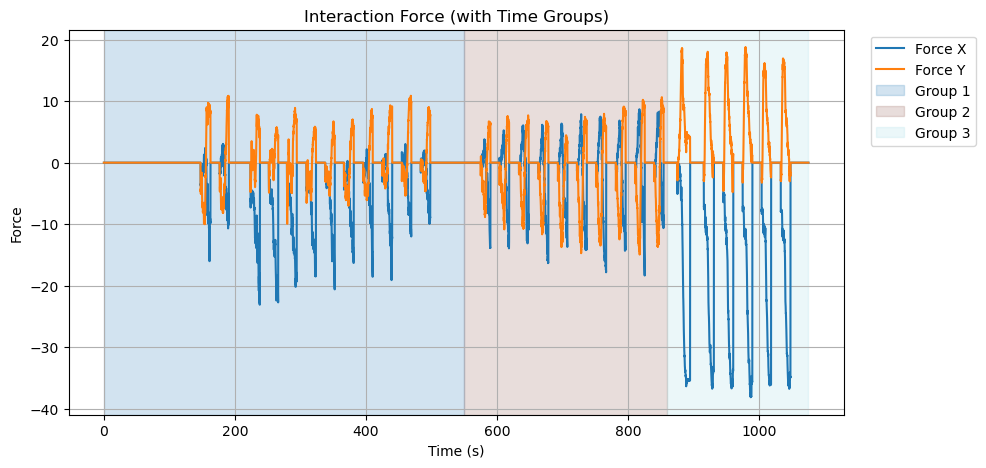

In [43]:
plt.figure(figsize=(10,5))
plt.plot(time, fx_traj, color='C0', label='Force X')
plt.plot(time, fy_traj, color='C1', label='Force Y')

# 구간 색깔 다르게 axvspan
# split_times = [400, 700]

group_names = []
start_time = 0

colors = plt.colormaps['tab20'].resampled(len(split_times)+1)
for idx, end_time in enumerate(split_times + [time[-1]]):  # 마지막 구간 추가
    plt.axvspan(start_time, end_time, color=colors(idx), alpha=0.2, label=f'Group {idx+1}')
    group_names.append((start_time, end_time, f'Group {idx+1}'))
    start_time = end_time

plt.title('Interaction Force (with Time Groups)')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1))
plt.grid(True)
plt.show()

### Choose Group

In [44]:
group_idx =2  # 바꿔서 group2, group3도 볼 수 있음
sample_rate = 50  # Hz

### Force Raw Data

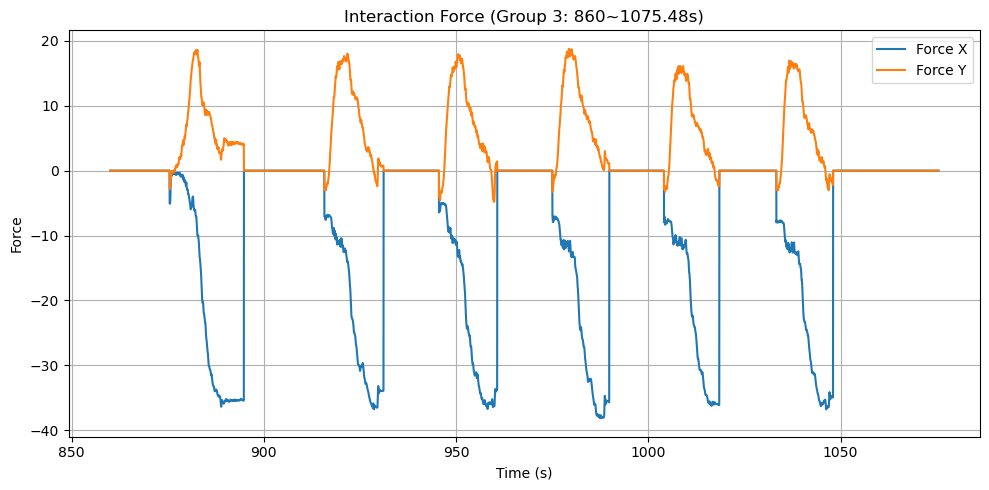

In [45]:
if group_idx == 0:
    start_time = 0
else:
    start_time = split_times[group_idx - 1]
if group_idx < len(split_times):
    end_time = split_times[group_idx]
else:
    end_time = time[-1]

mask = (time >= start_time) & (time < end_time)

plt.figure(figsize=(10,5))
plt.plot(time[mask], fx_traj[mask], color='C0', label='Force X')
plt.plot(time[mask], fy_traj[mask], color='C1', label='Force Y')

plt.title(f'Interaction Force (Group {group_idx+1}: {start_time}~{end_time}s)')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


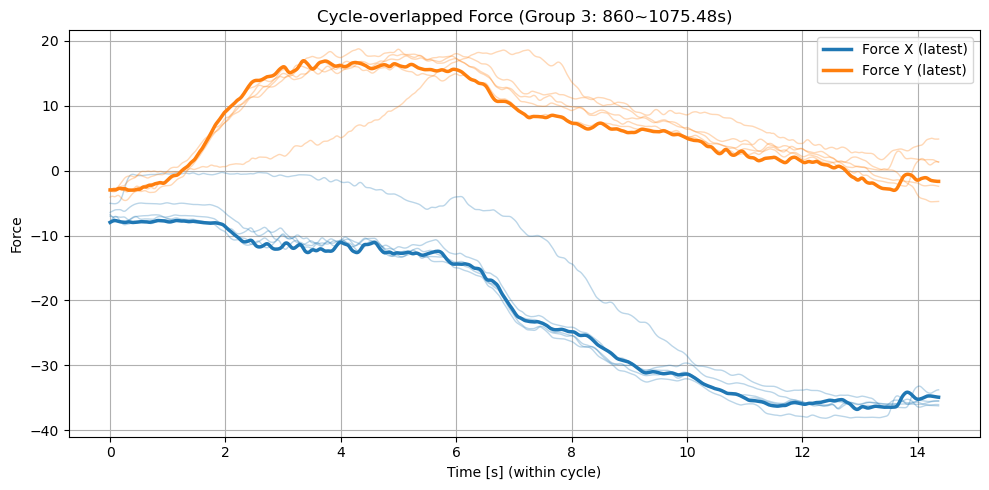

In [46]:
if group_idx == 0:
    start_time = 0
else:
    start_time = split_times[group_idx - 1]
if group_idx < len(split_times):
    end_time = split_times[group_idx]
else:
    end_time = time[-1]

mask = (time >= start_time) & (time < end_time)

time_g = time[mask]
fx_g = fx_traj[mask]
fy_g = fy_traj[mask]
traj_g = traj[mask]

# 2. Trajectory=1 구간의 시작, 끝 찾기 (rising/falling edge)
rising = np.where((traj_g[:-1] == 0) & (traj_g[1:] == 1))[0] + 1
falling = np.where((traj_g[:-1] == 1) & (traj_g[1:] == 0))[0] + 1

# 보정
if falling.size and rising.size:
    if falling[0] < rising[0]:
        falling = falling[1:]
    if len(rising) > len(falling):
        rising = rising[:len(falling)]

    # 3. 각 사이클별로 fx, fy 잘라서 저장
    fx_cycles = [fx_g[s:e] for s, e in zip(rising, falling)]
    fy_cycles = [fy_g[s:e] for s, e in zip(rising, falling)]

    # 4. 길이 맞추기 (짧은 길이 기준)
    min_len = min(len(fx) for fx in fx_cycles)
    fx_cycles = [fx[:min_len] for fx in fx_cycles]
    fy_cycles = [fy[:min_len] for fy in fy_cycles]
    time_short = np.arange(min_len) / sample_rate

    # 5. 플롯
    plt.figure(figsize=(10,5))
    # fx
    for fx in fx_cycles[:-1]:
        plt.plot(time_short, fx, color='C0', alpha=0.3, linewidth=1)
    plt.plot(time_short, fx_cycles[-1], color='C0', alpha=1.0, linewidth=2.5, label='Force X (latest)')
    # fy
    for fy in fy_cycles[:-1]:
        plt.plot(time_short, fy, color='C1', alpha=0.3, linewidth=1)
    plt.plot(time_short, fy_cycles[-1], color='C1', alpha=1.0, linewidth=2.5, label='Force Y (latest)')
    
    plt.title(f'Cycle-overlapped Force (Group {group_idx+1}: {start_time}~{end_time}s)')
    plt.xlabel('Time [s] (within cycle)')
    plt.ylabel('Force')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("사이클이 없습니다.")


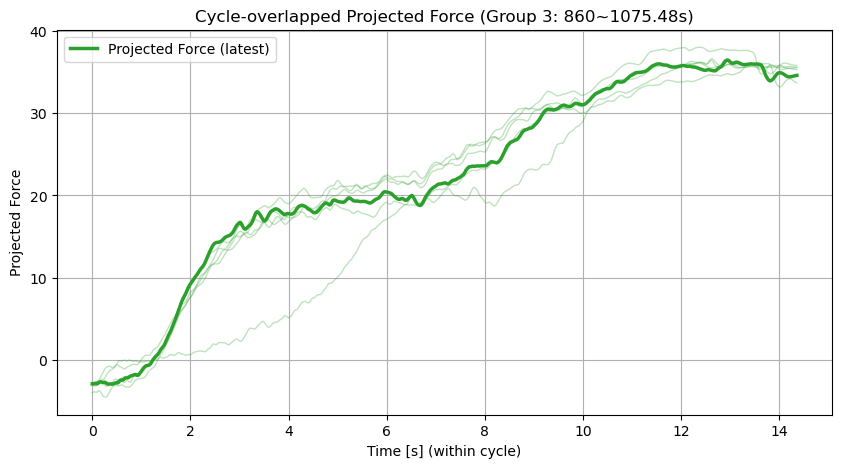

In [47]:
if group_idx == 0:
    start_time = 0
else:
    start_time = split_times[group_idx - 1]
if group_idx < len(split_times):
    end_time = split_times[group_idx]
else:
    end_time = time[-1]

mask = (time >= start_time) & (time < end_time)

time_g = time[mask]
pro_f_g = pro_f[mask]
traj_g = traj[mask]

# 2. Trajectory=1 구간의 시작, 끝 찾기 (rising/falling edge)
rising = np.where((traj_g[:-1] == 0) & (traj_g[1:] == 1))[0] + 1
falling = np.where((traj_g[:-1] == 1) & (traj_g[1:] == 0))[0] + 1

# 보정
if falling.size and rising.size:
    if falling[0] < rising[0]:
        falling = falling[1:]
    if len(rising) > len(falling):
        rising = rising[:len(falling)]

    # 3. 각 사이클별로 Projected Force 잘라서 저장
    pro_f_cycles = [pro_f_g[s:e] for s, e in zip(rising, falling)]

    # 4. 길이 맞추기 (짧은 길이 기준)
    min_len = min(len(pf) for pf in pro_f_cycles)
    pro_f_cycles = [pf[:min_len] for pf in pro_f_cycles]
    time_short = np.arange(min_len) / sample_rate

    # 5. 플롯
    plt.figure(figsize=(10,5))
    for pf in pro_f_cycles[:-1]:
        plt.plot(time_short, pf, color='C2', alpha=0.3, linewidth=1)
    plt.plot(time_short, pro_f_cycles[-1], color='C2', alpha=1.0, linewidth=2.5, label='Projected Force (latest)')
    
    plt.title(f'Cycle-overlapped Projected Force (Group {group_idx+1}: {start_time}~{end_time}s)')
    plt.xlabel('Time [s] (within cycle)')
    plt.ylabel('Projected Force')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("사이클이 없습니다.")


### Force Comparison

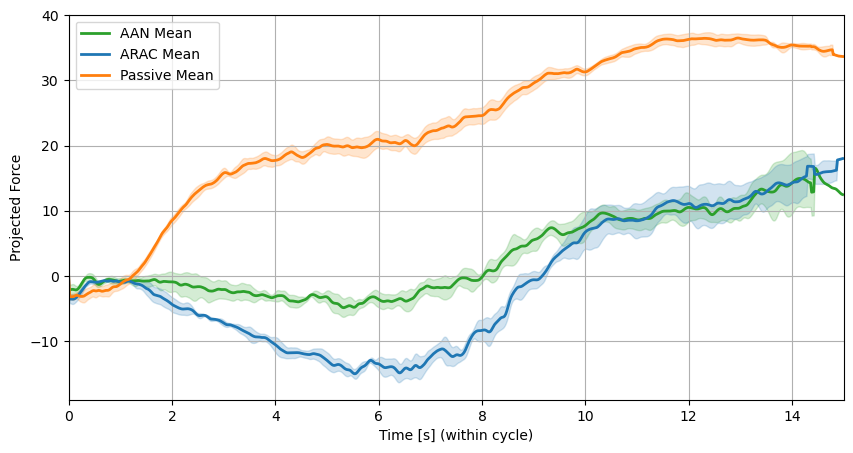

In [51]:
import numpy as np
import matplotlib.pyplot as plt

last_n = 4
group_colors = ['C2', 'C0', 'C1']
group_labels = [ 'AAN', 'ARAC', 'Passive',]

fixed_len = int(15 * sample_rate)  # 15초 길이

plt.figure(figsize=(10, 5))

for group_idx in range(len(split_times) + 1):
    # --- 구간 정의 ---

    if group_idx == 0:
        start_time = 0
    else:
        start_time = split_times[group_idx - 1]
    if group_idx < len(split_times):
        end_time = split_times[group_idx]
    else:
        end_time = time[-1]

    mask = (time >= start_time) & (time < end_time)
    time_g = time[mask]
    pro_f_g = pro_f[mask]
    traj_g = traj[mask]

    # --- 사이클 추출 ---
    rising = np.where((traj_g[:-1] == 0) & (traj_g[1:] == 1))[0] + 1
    falling = np.where((traj_g[:-1] == 1) & (traj_g[1:] == 0))[0] + 1

    # 보정
    if falling.size and rising.size:
        if falling[0] < rising[0]:
            falling = falling[1:]
        if len(rising) > len(falling):
            rising = rising[:len(falling)]

        pro_f_cycles = [pro_f_g[s:e] for s, e in zip(rising, falling)]
        if len(pro_f_cycles) < last_n:
            print(f"Group {group_idx+1}: 사이클 개수 부족")
            continue

        # --- NaN 패딩해서 15초로 맞추기 ---
        padded_cycles = []
        for pf in pro_f_cycles[-last_n:]:
            if len(pf) >= fixed_len:
                padded = pf[:fixed_len]
            else:
                padded = np.full(fixed_len, np.nan)
                padded[:len(pf)] = pf
            padded_cycles.append(padded)

        last_cycles = np.vstack(padded_cycles)
        mean_curve = np.nanmean(last_cycles, axis=0)
        std_curve = np.nanstd(last_cycles, axis=0)
        time_short = np.arange(fixed_len) / sample_rate

        # 그룹 2, 3에서 0초 위치는 0으로 (0.1초 → 0초로 수정 가능)
        if group_idx >= 1:
            zero_mask = time_short <= 0
            mean_curve[zero_mask] = 0
            std_curve[zero_mask] = 0

        # plot
        plt.plot(time_short, mean_curve, color=group_colors[group_idx], linewidth=2,
                 label=f'{group_labels[group_idx]} Mean')
        plt.fill_between(time_short, mean_curve - std_curve, mean_curve + std_curve,
                         color=group_colors[group_idx], alpha=0.2)

    else:
        print(f"Group {group_idx+1}: 사이클이 없습니다.")

plt.xlabel('Time [s] (within cycle)')
plt.ylabel('Projected Force')
plt.legend()
plt.grid(True)
plt.xlim(0, 15)
plt.show()


In [ ]:
# ---------------- ARAC 구간: 마지막 사이클 '끝 각도' ----------------
# 필요한 변수: sample_rate, split_times, time, traj, act_x, act_y
idx_arac = 1        # 0:AAN, 1:ARAC, 2:Passive

# 1) ARAC 범위 -------------------------------------------------------------
arac_start = 0 if idx_arac == 0 else split_times[idx_arac - 1]
arac_end   = time[-1] if idx_arac >= len(split_times) else split_times[idx_arac]

mask      = (time >= arac_start) & (time < arac_end)
mask_idx  = np.nonzero(mask)[0]       # 전역 인덱스 변환용
traj_g    = traj[mask]

# 2) 사이클 경계 -----------------------------------------------------------
rising  = np.where((traj_g[:-1] == 0) & (traj_g[1:] == 1))[0] + 1
falling = np.where((traj_g[:-1] == 1) & (traj_g[1:] == 0))[0] + 1
if rising.size and falling.size and falling[0] < rising[0]:
    falling = falling[1:]
rising = rising[:len(falling)]

if not rising.size:
    raise ValueError("ARAC 구간에서 유효한 사이클을 찾지 못했습니다.")

# 3) 마지막 사이클의 '끝 각도' ---------------------------------------------
s_last, e_last = rising[-1], falling[-1]    # e_last는 슬라이스에서 제외될 인덱스
idx_glob = mask_idx[e_last - 1]             # 마지막 샘플(시간상 끝점)

last_angle = np.degrees(np.arctan2(act_y[idx_glob], act_x[idx_glob]))
print(f"Last cycle end-point angle (ARAC): {last_angle:.2f}°")


Last cycle end-point angle (ARAC): 87.17°


In [ ]:
# 87.17°
# 84.64°
# 85.53°
# 85.46°
# 85.13°
# 82.85°
# 87.18°
# 86.16°


=== Positive Impulse (N·s) ===
AAN     :   65.01
ARAC    :   61.44
Passive :  349.15


<Figure size 1000x500 with 0 Axes>

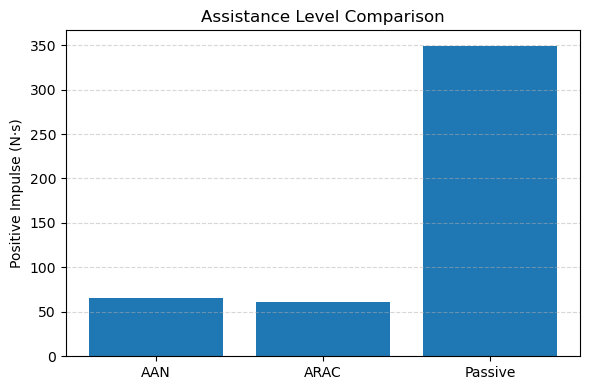


=== Resistive Impulse after 2 s (|N·s|) ===
AAN     :   16.28
ARAC    :   69.89
Passive :    0.00


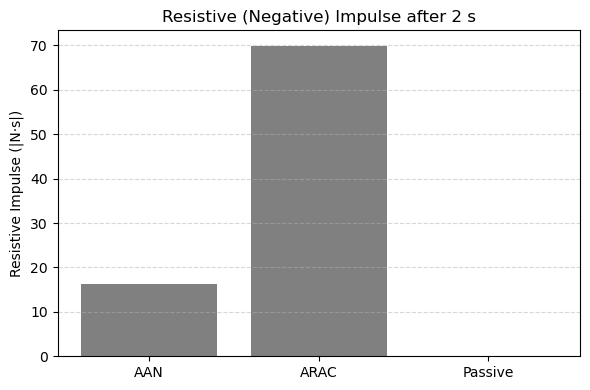

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# 사용자 정의 파라미터
last_n = 4                       # 마지막 n 사이클 평균
group_colors = ['C2', 'C0', 'C1']
group_labels = ['AAN', 'ARAC', 'Passive']
fixed_len = int(15 * sample_rate)   # 15 s → 샘플 수
# --------------------------------------------------

# 0) 컨테이너를 루프 바깥에서 "한 번만" 선언
mean_curves = {}
std_curves  = {}
time_short  = np.arange(fixed_len) / sample_rate

# ---------- ① 그룹별 mean / std 곡선 계산 ----------
plt.figure(figsize=(10, 5))

for group_idx in range(len(split_times) + 1):
    label = group_labels[group_idx]

    # --- 구간 정의 ---
    start_time = 0 if group_idx == 0 else split_times[group_idx - 1]
    end_time   = time[-1] if group_idx == len(split_times) else split_times[group_idx]

    mask     = (time >= start_time) & (time < end_time)
    time_g   = time[mask]
    pro_f_g  = pro_f[mask]
    traj_g   = traj[mask]

    # --- 사이클 추출 ---
    rising   = np.where((traj_g[:-1] == 0) & (traj_g[1:] == 1))[0] + 1
    falling  = np.where((traj_g[:-1] == 1) & (traj_g[1:] == 0))[0] + 1

    if rising.size and falling.size:
        if falling[0] < rising[0]:  falling = falling[1:]
        if len(rising) > len(falling): rising = rising[:len(falling)]

        pro_f_cycles = [pro_f_g[s:e] for s, e in zip(rising, falling)]
        if len(pro_f_cycles) < last_n:
            print(f"{label}: 사이클 부족 → 건너뜀 ({len(pro_f_cycles)}/{last_n})")
            continue

        # --- 15 s 길이로 NaN 패딩 ---
        padded = []
        for pf in pro_f_cycles[-last_n:]:
            if len(pf) >= fixed_len:            padded.append(pf[:fixed_len])
            else:
                tmp = np.full(fixed_len, np.nan)
                tmp[:len(pf)] = pf
                padded.append(tmp)

        last_cycles = np.vstack(padded)
        mean_curve  = np.nanmean(last_cycles, axis=0)
        std_curve   = np.nanstd(last_cycles,  axis=0)

        # 그룹 2·3의 t=0 부근 0으로 클리핑(원하면 조정)
        if group_idx >= 1:
            zero_mask = time_short <= 0
            mean_curve[zero_mask] = 0
            std_curve[zero_mask]  = 0

        # ★★ 반드시 저장! ─────────────────
        mean_curves[label] = mean_curve
        std_curves[label]  = std_curve
        # ────────────────────────────────

        # 시각화
        # plt.plot(time_short, mean_curve, color=group_colors[group_idx], lw=2, label=f'{label} Mean')
        # plt.fill_between(time_short, mean_curve - std_curve, mean_curve + std_curve,
        #                  color=group_colors[group_idx], alpha=0.2)
    else:
        print(f"{label}: 사이클 검출 실패")

# plt.xlabel('Time [s] (within cycle)')
# plt.ylabel('Projected Force')
# plt.legend(); plt.grid(True); plt.xlim(0, 15); plt.tight_layout()
# plt.show()

# ---------- ② 양수 구간 적분해 Impulse 비교 ----------
areas = {}
dt = 1 / sample_rate

print("\n=== Positive Impulse (N·s) ===")
for label, curve in mean_curves.items():
    pos  = np.clip(curve, 0, None)          # 음수 → 0
    pos  = np.nan_to_num(pos, nan=0.0)      # NaN → 0
    area = np.trapezoid(pos, dx=dt)
    areas[label] = area
    print(f"{label:8s}: {area:7.2f}")

# 시각화
plt.figure(figsize=(6, 4))
plt.bar(areas.keys(), areas.values())
plt.ylabel('Positive Impulse (N·s)')
plt.title('Assistance Level Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------- ③ 2 초 이후 음수(저항) 구간 적분 ----------
resist_areas = {}
dt = 1 / sample_rate
idx_after2 = time_short > 2          # 2 s 초과 구간 인덱스

print("\n=== Resistive Impulse after 2 s (|N·s|) ===")
for label, curve in mean_curves.items():
    seg = curve[idx_after2]                  # 2 초 이후 데이터
    neg = np.clip(seg, None, 0)              # 양수 → 0, 음수만 남김
    neg = np.nan_to_num(neg, nan=0.0)        # NaN → 0
    area = np.trapezoid(-neg, dx=dt)         # 절댓값 적분
    resist_areas[label] = area
    print(f"{label:8s}: {area:7.2f}")

# ---------- 막대그래프 ----------
plt.figure(figsize=(6, 4))
plt.bar(resist_areas.keys(), resist_areas.values(), color='gray')
plt.ylabel('Resistive Impulse (|N·s|)')
plt.title('Resistive (Negative) Impulse after 2 s')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
for s, e in zip(rising, falling):
    print(f'cycle length (s): {(e-s)/sample_rate:.2f}')
print("mean_curve after 2 s (first 10 samples):", mean_curve[idx_after2][:10])

cycle length (s): 19.32
cycle length (s): 15.40
cycle length (s): 15.14
cycle length (s): 14.80
cycle length (s): 14.38
cycle length (s): 14.74
mean_curve after 2 s (first 10 samples): [ 8.66426865  8.8166058   8.99218063  9.19472777  9.40751539  9.60924347
  9.80814231 10.00524692 10.19644328 10.3811737 ]


In [ ]:
for group_idx in range(len(split_times) + 1):
    label = group_labels[group_idx]
    print('----', label, '----')

    # 0) 구간 마스크
    # ... (기존 내용 동일)

    # 1) rising / falling 검출 결과
    print('  rising:', len(rising), 'points,  falling:', len(falling), 'points')

    # 2) 사이클 개수
    print('  cycles found:', len(rising), '(need ≥', last_n, ')')

    # 3) mean_curve 저장 유무
    if label in mean_curves:
        print('  mean_curve length:', len(mean_curves[label]))
    else:
        print('  mean_curve NOT stored')


---- AAN ----
  rising: 6 points,  falling: 6 points
  cycles found: 6 (need ≥ 4 )
  mean_curve length: 750
---- ARAC ----
  rising: 6 points,  falling: 6 points
  cycles found: 6 (need ≥ 4 )
  mean_curve length: 750
---- Passive ----
  rising: 6 points,  falling: 6 points
  cycles found: 6 (need ≥ 4 )
  mean_curve length: 750


In [ ]:
# —— ARAC 그룹 마지막 N 사이클의 zero crossing per-cycle + 평균 출력 셀 ——

import numpy as np

# Parameters you already have:
# sample_rate, split_times, time, traj, pro_f, act_x, act_y, last_n = 4

# 1) ARAC 구간 정의
idx_arac   = 1  # 0:AAN, 1:ARAC, 2:Passive
arac_start = 0 if idx_arac == 0 else split_times[idx_arac - 1]
arac_end   = time[-1] if idx_arac >= len(split_times) else split_times[idx_arac]

# 2) 구간 마스크 및 원본 인덱스
mask     = (time >= arac_start) & (time < arac_end)
mask_idx = np.nonzero(mask)[0]
pro_f_g  = pro_f[mask]
traj_g   = traj[mask]

# 3) 사이클 경계(rising→falling) 찾기
rising   = np.where((traj_g[:-1] == 0) & (traj_g[1:] == 1))[0] + 1
falling  = np.where((traj_g[:-1] == 1) & (traj_g[1:] == 0))[0] + 1
# 보정
if falling.size and rising.size and falling[0] < rising[0]:
    falling = falling[1:]
if len(rising) > len(falling):
    rising = rising[:len(falling)]

# 4) 마지막 up to last_n 사이클 선택
cycles = list(zip(rising, falling))
to_use = cycles[-min(len(cycles), last_n):]

# 5) per-cycle zero crossing time & angle 계산 및 출력
times_rel = []
angles    = []

for idx, (s, e) in enumerate(to_use, start=1):
    segment = pro_f_g[s:e]
    # cycle 내 zero crossing 인덱스
    zcs = np.where(np.sign(segment[:-1]) * np.sign(segment[1:]) < 0)[0]
    if not zcs.size:
        print(f"Cycle {idx}: zero crossing not found")
        continue
    z_rel = zcs[-1]
    # 전역 인덱스로 변환
    idx_glob = mask_idx[s + z_rel]
    x0, y0  = act_x[idx_glob], act_y[idx_glob]

    # 상대 시간과 각도 계산
    t_rel = z_rel / sample_rate
    ang   = np.degrees(np.arctan2(y0, x0))

    times_rel.append(t_rel)
    angles.append(ang)
    print(f"Cycle {idx}: zero crossing relative time = {t_rel:.3f}s, angle = {ang:.2f}°")

# 6) 평균 출력
if times_rel:
    mean_time  = np.mean(times_rel)
    mean_angle = np.mean(angles)
    print(f"\nAverage zero crossing relative time: {mean_time:.3f}s")
    print(f"Average zero crossing angle:         {mean_angle:.2f}°")
else:
    print("No valid zero crossings found in the last cycles.")


Cycle 1: zero crossing relative time = 9.120s, angle = 59.37°
Cycle 2: zero crossing relative time = 8.920s, angle = 56.79°
Cycle 3: zero crossing relative time = 8.640s, angle = 53.44°
Cycle 4: zero crossing relative time = 9.260s, angle = 61.12°

Average zero crossing relative time: 8.985s
Average zero crossing angle:         57.68°


### Error Raw Data 

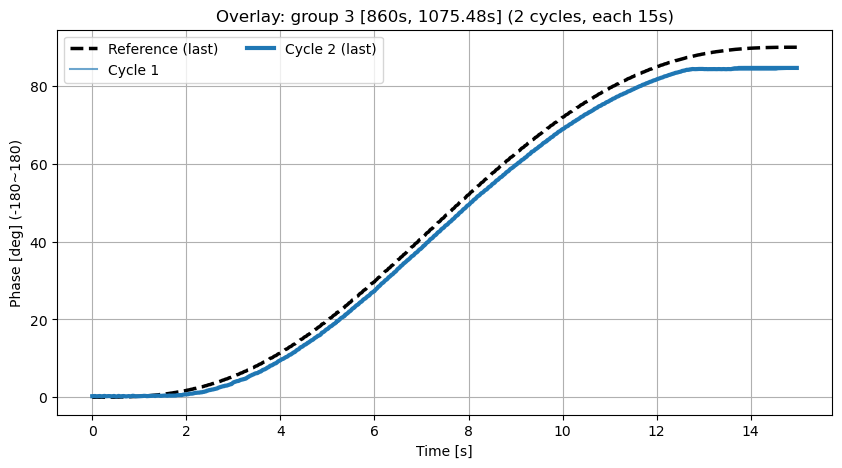

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

cut_sec      = 15             # 각 cycle 길이(초)
num_cycles   = 2             # 마지막 몇 개 cycle을 볼지
base_color   = 'C0'           # 그래프 색상
sample_rate  = 50

# ------------------------------
# group_idx = 1                 # 0부터 시작 (0: group1, 1: group2, ...)

# === 데이터 로드 ===
traj   = tdms[group]['Trajectory'][:]
ref_x  = tdms[group]['Reference Position X'][:]
ref_y  = tdms[group]['Reference Position Y'][:]
act_x  = tdms[group]['Measured Position X'][:]
act_y  = tdms[group]['Measured Position Y'][:]
time   = np.arange(len(traj)) / sample_rate

# === 그룹 인덱스에 따른 시간 구간 ===
if group_idx == 0:
    start_time = 0
    end_time = split_times[0]
elif group_idx < len(split_times):
    start_time = split_times[group_idx-1]
    end_time = split_times[group_idx]
else:
    start_time = split_times[-1]
    end_time = time[-1]

mask = (time >= start_time) & (time < end_time)
traj_g   = traj[mask]
ref_x_g  = ref_x[mask]
ref_y_g  = ref_y[mask]
act_x_g  = act_x[mask]
act_y_g  = act_y[mask]

# === phase 계산 ===
traj_bin = (traj_g > 0.5).astype(int)
phase_ref_deg = np.degrees((np.arctan2(ref_y_g, ref_x_g) + 2*np.pi) % (2*np.pi))
phase_act_deg = np.degrees((np.arctan2(act_y_g, act_x_g) + 2*np.pi) % (2*np.pi))
phase_ref_deg = ((phase_ref_deg + 180) % 360) - 180
phase_act_deg = ((phase_act_deg + 180) % 360) - 180

# === 사이클 추출 ===
cut_len = int(cut_sec * sample_rate)
rising_idx = np.where((traj_bin[:-1] == 0) & (traj_bin[1:] == 1))[0] + 1

segments_act, segments_ref = [], []
for s in rising_idx[-num_cycles:]:
    if s + cut_len <= len(traj_bin):
        seg_act = phase_act_deg[s:s+cut_len].copy()
        seg_ref = phase_ref_deg[s:s+cut_len].copy()
        segments_act.append(seg_act)
        segments_ref.append(seg_ref)

if not segments_act:
    print(f"group {group_idx+1}: 추출된 cycle이 없습니다.")
else:
    segments_act = np.vstack(segments_act)
    segments_ref = np.vstack(segments_ref)
    t_short = np.arange(cut_len) / sample_rate

    plt.figure(figsize=(10,5))
    plt.plot(t_short, segments_ref[-1], color='black', linestyle='--', linewidth=2.5, label='Reference (last)')
    for idx2, seg in enumerate(segments_act):
        alpha = 0.3 + 0.7 * (idx2+1)/len(segments_act)
        lw = 1.5 if idx2 < len(segments_act)-1 else 3
        label = f'Cycle {idx2+1}' if idx2 < len(segments_act)-1 else f'Cycle {idx2+1} (last)'
        plt.plot(t_short, seg, color=base_color, alpha=alpha, lw=lw, label=label)
    plt.xlabel('Time [s]')
    plt.ylabel('Phase [deg] (-180~180)')
    plt.title(f'Overlay: group {group_idx+1} [{start_time}s, {end_time}s] ({len(segments_act)} cycles, each {cut_sec}s)')
    plt.legend(ncol=2)
    plt.grid(True)
    # plt.tight_layout()
    plt.show()


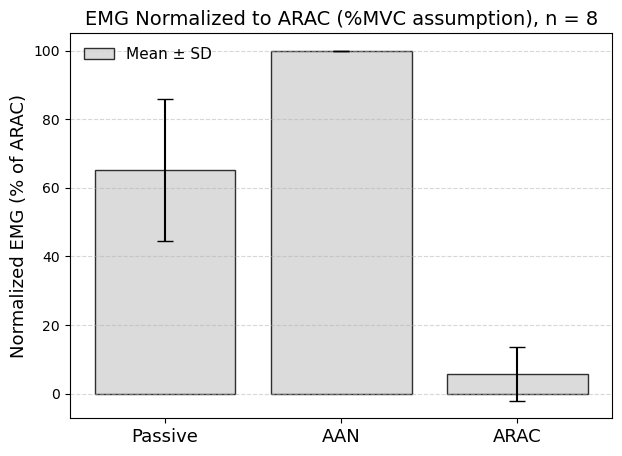

In [ ]:
import numpy as np
import matplotlib.pyplot as plt




import numpy as np

# 각 참가자 데이터
participant1 = [0.01566232191896718, 0.043164304562662285, 9.617439800402768e-05]
participant2 = [0.016462179021517673, 0.0226162091808534, 0.00027636916716296576]
participant3 = [0.022468912927915502, 0.0557723750124688, 4.854089555987785e-05]
participant4 = [0.04106333758357777, 0.04464540231822996, 0.01033633330224644]
participant5 = [0.005031651869630344, 0.006335565083385888, 8.632001826431004e-05]
participant6 = [0.001990081656240324, 0.002325492302681139, 0.00024732700164244105]
participant7 = [0.00393775684971357, 0.006326075263996409, 0.00019177317831647601]
participant8 = [0.025891210219886687, 0.048203837196008494, 0.003232644686684996]

# 배열로 묶기
data = np.vstack([
    participant1,
    participant2,
    participant3,
    participant4,
    participant5,
    participant6,
    participant7,
    participant8
])  # shape: (8, 3)

# 결과 확인
# print(data)

n_participants = data.shape[0]
group_labels = ['Passive', 'AAN', 'ARAC']
x = np.arange(len(group_labels))

# (1) 정규화: 각 행의 마지막 값(ARAC)을 기준으로 %MVC 계산
data_norm = (data.T / data[:, -2]).T * 100  # ARAC 기준 정규화

# (2) 평균과 표준편차
mean_vals = data_norm.mean(axis=0)
sd_vals = data_norm.std(axis=0, ddof=1)

# (3) 시각화
plt.figure(figsize=(7,5))

# 평균 ± SD 막대 그래프
plt.bar(x, mean_vals, yerr=sd_vals, capsize=6, color='lightgray', edgecolor='k', alpha=0.8, label='Mean ± SD')

# 개별 피험자 점 + 선
# for i in range(n_participants):
#     plt.plot(x, data_norm[i], marker='o', linestyle='-', linewidth=1, markersize=7, label=f'P{i+1}' if i==0 else "")

# 시각화 설정
plt.xticks(x, group_labels, fontsize=13)
plt.ylabel('Normalized EMG (% of ARAC)', fontsize=13)
plt.title(f'EMG Normalized to ARAC (%MVC assumption), n = {n_participants}', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.ylim(0, 120)
# plt.tight_layout()
plt.legend(loc='upper left', fontsize=11, frameon=False)
plt.show()


In [ ]:
# ❶ 마지막 segment 길이 확인
print("seg_ref length :", len(segments_ref[-1]), " / cut_len :", cut_len)

# ❷ NaN 존재 여부
print("NaNs in seg_ref :", np.isnan(segments_ref[-1]).sum())


seg_ref length : 750  / cut_len : 750
NaNs in seg_ref : 0


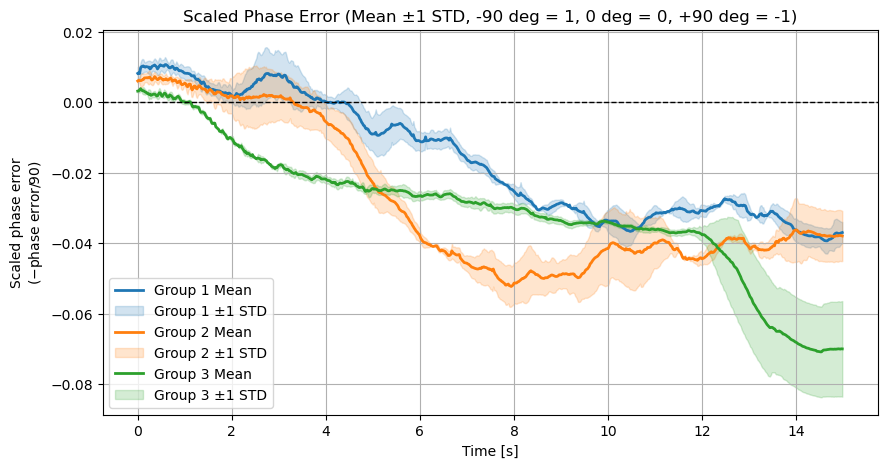

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

split_times  = [400, 700]
cut_sec      = 15
num_cycles   = 3
group_colors = ['C0', 'C1', 'C2']
group_labels = ['Group 1', 'Group 2', 'Group 3']
sample_rate  = 50

traj   = tdms[group]['Trajectory'][:]
ref_x  = tdms[group]['Reference Position X'][:]
ref_y  = tdms[group]['Reference Position Y'][:]
act_x  = tdms[group]['Measured Position X'][:]
act_y  = tdms[group]['Measured Position Y'][:]
time   = np.arange(len(traj)) / sample_rate

plt.figure(figsize=(10,5))

for group_idx in range(len(split_times)+1):
    if group_idx == 0:
        start_time = 0
        end_time = split_times[0]
    elif group_idx < len(split_times):
        start_time = split_times[group_idx-1]
        end_time = split_times[group_idx]
    else:
        start_time = split_times[-1]
        end_time = time[-1]

    mask = (time >= start_time) & (time < end_time)
    traj_g   = traj[mask]
    ref_x_g  = ref_x[mask]
    ref_y_g  = ref_y[mask]
    act_x_g  = act_x[mask]
    act_y_g  = act_y[mask]

    traj_bin = (traj_g > 0.5).astype(int)
    phase_ref_deg = np.degrees((np.arctan2(ref_y_g, ref_x_g) + 2*np.pi) % (2*np.pi))
    phase_act_deg = np.degrees((np.arctan2(act_y_g, act_x_g) + 2*np.pi) % (2*np.pi))
    phase_ref_deg = ((phase_ref_deg + 180) % 360) - 180
    phase_act_deg = ((phase_act_deg + 180) % 360) - 180

    phase_err = phase_ref_deg - phase_act_deg
    phase_err = (phase_err + 180) % 360 - 180

    cut_len = int(cut_sec * sample_rate)
    rising_idx = np.where((traj_bin[:-1] == 0) & (traj_bin[1:] == 1))[0] + 1

    segments_err = []
    for s in rising_idx[-num_cycles:]:
        if s + cut_len <= len(traj_bin):
            seg_err = phase_err[s:s+cut_len].copy()
            segments_err.append(seg_err)

    if not segments_err:
        print(f"Group {group_idx+1}: 추출된 cycle이 없습니다.")
        continue

    segments_err = np.vstack(segments_err)
    t_short = np.arange(cut_len) / sample_rate

    scaled_mean = np.mean(segments_err / -90, axis=0)
    scaled_std  = np.std(segments_err / -90, axis=0)

    plt.plot(t_short, scaled_mean, color=group_colors[group_idx], lw=2, label=f'{group_labels[group_idx]} Mean')
    plt.fill_between(t_short, scaled_mean-scaled_std, scaled_mean+scaled_std,
                     color=group_colors[group_idx], alpha=0.2, label=f'{group_labels[group_idx]} ±1 STD')

plt.axhline(0, color='k', linestyle='--', lw=1)
plt.xlabel('Time [s]')
plt.ylabel('Scaled phase error\n$(-$phase error$/90)$')
plt.title('Scaled Phase Error (Mean ±1 STD, -90 deg = 1, 0 deg = 0, +90 deg = -1)')
plt.legend()
plt.grid(True)
plt.show()


### RBF Raw Data

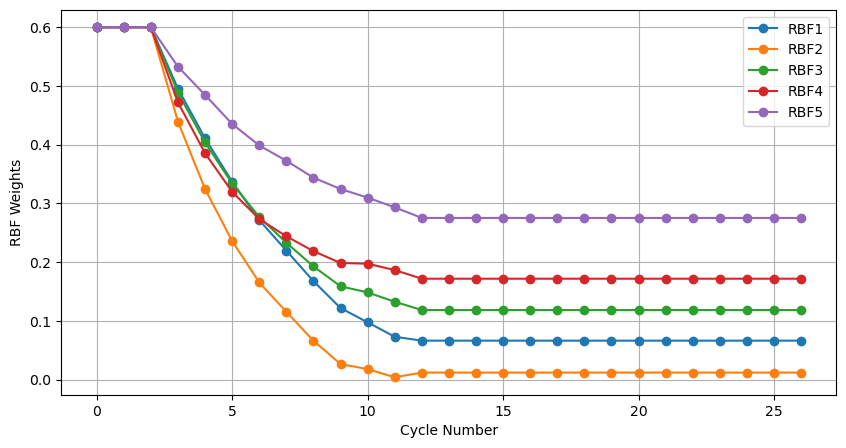

In [ ]:
w1   = tdms[group]['RBF1'][:] 
w2   = tdms[group]['RBF2'][:]
w3   = tdms[group]['RBF3'][:]
w4   = tdms[group]['RBF4'][:]
w5   = tdms[group]['RBF5'][:]  # 필요시 사용
traj = tdms[group]['Trajectory'][:]
time = np.arange(len(w1)) / 50   # sample_rate = 50 Hz

# 3) Trajectory rising edge 인덱스 (0→1)
rising_idx = np.where((traj[:-1] == 0) & (traj[1:] == 1))[0] + 1

# 4) 600초 이후의 rising edge만
rising_idx = rising_idx[:-1]

# 5) 해당 시점의 RBF 값들
w1_rise = w1[rising_idx]
w2_rise = w2[rising_idx]
w3_rise = w3[rising_idx]
w4_rise = w4[rising_idx]  # 필요시 사용
w5_rise = w5[rising_idx]  # 필요시 사용

# 6) x축을 '사이클 번호(=rising edge 개수)'로
cycle_nums = np.arange(len(rising_idx))  # 0, 1, 2, ...

plt.figure(figsize=(10,5))
plt.plot(cycle_nums, w1_rise, '-o', color='C0', label='RBF1')
plt.plot(cycle_nums, w2_rise, '-o', color='C1', label='RBF2')
plt.plot(cycle_nums, w3_rise, '-o', color='C2', label='RBF3')
plt.plot(cycle_nums, w4_rise, '-o', color='C3', label='RBF4')  # 필요시 사용
plt.plot(cycle_nums, w5_rise, '-o', color='C4', label='RBF5')  # 필요시 사용

plt.xlabel('Cycle Number')
plt.ylabel('RBF Weights')
plt.legend()
plt.grid(True)
plt.show()

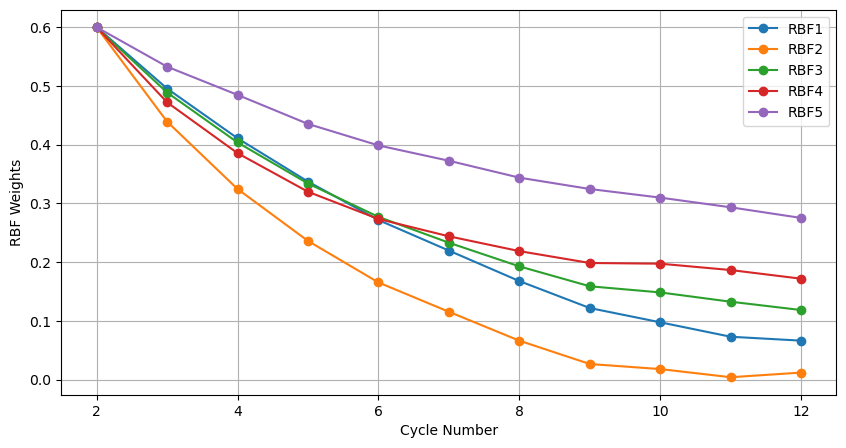

In [ ]:
# 원하는 사이클 범위 지정
start_cycle = 2
end_cycle = 12  # 예: 10번부터 20번까지

# 인덱스 슬라이싱: 정수 인덱스 사용
selected_idx = np.arange(start_cycle, end_cycle + 1)

# 시각화
plt.figure(figsize=(10,5))
plt.plot(selected_idx, w1_rise[selected_idx], '-o', color='C0', label='RBF1')
plt.plot(selected_idx, w2_rise[selected_idx], '-o', color='C1', label='RBF2')
plt.plot(selected_idx, w3_rise[selected_idx], '-o', color='C2', label='RBF3')
plt.plot(selected_idx, w4_rise[selected_idx], '-o', color='C3', label='RBF4')  # 필요시 사용
plt.plot(selected_idx, w5_rise[selected_idx], '-o', color='C4', label='RBF5')  # 필요시 사용

plt.xlabel('Cycle Number')
plt.ylabel('RBF Weights')
plt.legend()
plt.grid(True)
plt.show()


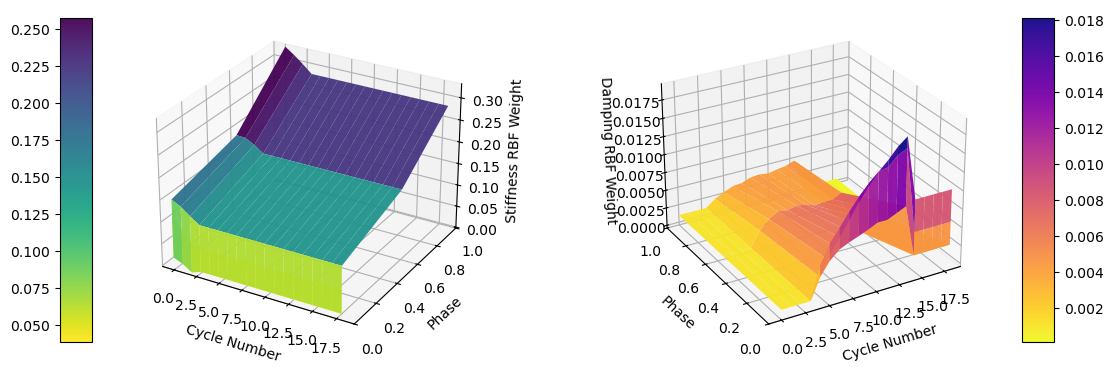

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


sample_rate = 50

w1 = tdms[group]['RBF1'][:]
w2 = tdms[group]['RBF2'][:]
w3 = tdms[group]['RBF3'][:]
w4 = tdms[group]['RBF4'][:]
w5 = tdms[group]['RBF5'][:]
d1 = tdms[group]['Damp1'][:]
d2 = tdms[group]['Damp2'][:]
d3 = tdms[group]['Damp3'][:]
d4 = tdms[group]['Damp4'][:]
d5 = tdms[group]['Damp5'][:]
traj = tdms[group]['Trajectory'][:]

time = np.arange(len(traj)) / sample_rate

# group1+2 범위 (0~700초)
start_time = split_times[0]
end_time = time[-1]
mask = (time >= start_time) & (time < end_time)

w1_g = w1[mask]
w2_g = w2[mask]
w3_g = w3[mask]
w4_g = w4[mask]
w5_g = w5[mask]
d1_g = d1[mask]
d2_g = d2[mask]
d3_g = d3[mask]
d4_g = d4[mask]
d5_g = d5[mask]
traj_g = traj[mask]

rising_idx = np.where((traj_g[:-1] == 0) & (traj_g[1:] == 1))[0] + 1
cycle_nums = np.arange(len(rising_idx))

# (num_cycles, 5) 2D 배열
W = np.vstack([w1_g[rising_idx], w2_g[rising_idx], w3_g[rising_idx], w4_g[rising_idx], w5_g[rising_idx]]).T
D = np.vstack([d1_g[rising_idx], d2_g[rising_idx], d3_g[rising_idx], d4_g[rising_idx], d5_g[rising_idx]]).T

num_cycles = W.shape[0]
# phase_labels = np.linspace(0, 1, 5)
# PHASE, CYC = np.meshgrid(phase_labels, cycle_nums)
phase_labels = np.linspace(-1.1, 1.1, 5)  # 예: -0.2, 0.0, 0.3, ..., 1.2
PHASE, CYC = np.meshgrid(phase_labels, cycle_nums)

fig = plt.figure(figsize=(13,6))  # 더 넓게

# --- RBF 면 plot (x: Cycle Number, y: Phase 0~1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax.plot_surface(CYC, np.clip(PHASE, 0, 1), W, cmap='viridis_r', edgecolor='none', alpha=0.95)
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Phase')
ax.set_zlabel('Stiffness RBF Weight')
# ax.set_title(f'RBF (Stiffness) Surface: Group 1+2 (0~700s)')
# ax.view_init(elev=27, azim=-120)
ax.view_init(elev=27, azim=-60)  # 시점 조정
ax.set_ylim(0, 1)

cb1 = fig.colorbar(surf1, ax=ax, location='left', shrink=0.7, aspect=10, pad=0.10)

# --- Damping 면 plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(CYC, np.clip(PHASE, 0, 1), D, cmap='plasma_r', edgecolor='none', alpha=0.95)
ax2.set_xlabel('Cycle Number')
ax2.set_ylabel('Phase')
ax2.set_zlabel('Damping RBF Weight')
# ax2.set_title(f'Damping Surface: Group 1+2 (0~700s)')
ax2.view_init(elev=27, azim=-120)
ax2.set_ylim(0, 1)

cb2 = fig.colorbar(surf2, ax=ax2, shrink=0.7, aspect=10, pad=0.10)

plt.subplots_adjust(left=0.13, right=0.95, wspace=0.35)
plt.show()


### Parameter Update Visualization

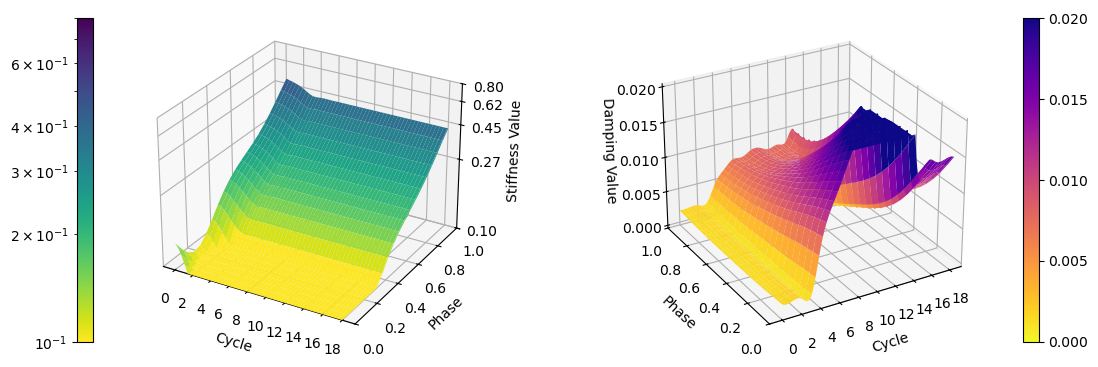

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize, LogNorm   # LogNorm만 추가
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

# ──────────────────────────────────────────────────────────
# (0) RBF(Stiffness) z-축 범위 지정 ─ 원하는 값으로만 수정
# ──────────────────────────────────────────────────────────
zlim_rbf = (1e-1, 0.8)          # (min, max) in LINEAR scale

# ──────────────────────────────────────────────────────────
# (1) 데이터 준비 ─ rising_idx, W, D 등은 기존 코드와 동일
# ──────────────────────────────────────────────────────────
num_cycles, num_basis = W.shape
phase_dense = np.linspace(0, 1, 20)
centers     = np.linspace(-0.2, 1.2, num_basis)
std         = 0.2

# --- RBF 가중합 계산 ---------------------------------------------------------
rbf_sum = []
for c in range(num_cycles):
    y = np.zeros_like(phase_dense)
    for i in range(num_basis):
        basis = norm.pdf(phase_dense, loc=centers[i], scale=std)
        basis /= basis.max()
        y += W[c, i] * basis
    rbf_sum.append(y)

# --- Damping 가중합 계산 (원본 그대로) ----------------------------------------
damp_sum = []
for c in range(num_cycles):
    y = np.zeros_like(phase_dense)
    for i in range(num_basis):
        basis = norm.pdf(phase_dense, loc=centers[i], scale=std)
        basis /= basis.max()
        y += D[c, i] * basis
    damp_sum.append(y)

# ──────────────────────────────────────────────────────────
# (2) cycle 방향 보간
# ──────────────────────────────────────────────────────────
factor       = 10
cycle_dense  = np.linspace(0, num_cycles - 1, num_cycles * factor)

interp_kind  = 'cubic'
rbf_dense  = interp1d(np.arange(num_cycles), rbf_sum,
                      axis=0, kind=interp_kind)(cycle_dense)
damp_dense = interp1d(np.arange(num_cycles), damp_sum,
                      axis=0, kind=interp_kind)(cycle_dense)

# 원래 코드와 동일한 clip
rbf_dense  = np.clip(rbf_dense,  0, 0.8)
damp_dense = np.clip(damp_dense, 0, 0.02)

# ──────────────────────────────────────────────────────────
# (2½) RBF 전용: 로그 변환용 데이터 준비
# ──────────────────────────────────────────────────────────
eps              = zlim_rbf[0]                     # 0 회피
rbf_clip         = np.clip(rbf_dense, eps, None)
rbf_dense_log10  = np.log10(rbf_clip)              # plot_surface용 z

# ──────────────────────────────────────────────────────────
# (3) 서피스 플롯
# ──────────────────────────────────────────────────────────
CYC_dense, PHASE_dense = np.meshgrid(cycle_dense, phase_dense, indexing='ij')
fig = plt.figure(figsize=(13, 6))

# ─── RBF(Stiffness) Surface (왼쪽, log-z) ────────────────────────────────
ax = fig.add_subplot(1, 2, 1, projection='3d')

norm_rbf   = LogNorm(vmin=zlim_rbf[0], vmax=zlim_rbf[1])
colors_rbf = cm.viridis_r(norm_rbf(rbf_clip))

ax.plot_surface(
    CYC_dense, PHASE_dense, rbf_dense_log10,     # 로그 z 데이터
    facecolors=colors_rbf,
    linewidth=0, antialiased=True, shade=False
)

ax.set_xlabel('Cycle')
ax.set_ylabel('Phase')
ax.set_zlabel('Stiffness Value')

# z축 눈금 (원래 단위로 표시)
tick_vals = np.geomspace(*zlim_rbf, 5)
ax.set_zticks(np.log10(tick_vals))
# ax.set_zticklabels([f'{v}' for v in tick_vals])
ax.set_zlim(np.log10(zlim_rbf))
ticks = np.log10(np.linspace(zlim_rbf[0], zlim_rbf[1], 5))
ax.set_zticks(ticks)
ax.set_zticklabels([f'{10**t:.2f}' for t in ticks])


ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(0, 1)
ax.view_init(elev=27, azim=-60)

fig.colorbar(
    cm.ScalarMappable(norm=norm_rbf, cmap='viridis_r'),
    ax=ax, location='left', shrink=0.7, pad=0.10
)

# ─── Damping Surface (오른쪽, 원본 그대로) ────────────────────────────────
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

norm_damp   = Normalize(vmin=damp_dense.min(), vmax=damp_dense.max())
colors_damp = cm.plasma_r(norm_damp(damp_dense))

ax2.plot_surface(
    CYC_dense, PHASE_dense, damp_dense,          # 수정 없음
    facecolors=colors_damp,
    linewidth=0, antialiased=True, shade=False
)

ax2.set_xlabel('Cycle')
ax2.set_ylabel('Phase')
ax2.set_zlabel('Damping Value')
ax2.set_zticks(np.linspace(0, 0.02, 5))

ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylim(0, 1)
ax2.view_init(elev=27, azim=-120)

fig.colorbar(
    cm.ScalarMappable(norm=norm_damp, cmap='plasma_r'),
    ax=ax2, shrink=0.7, pad=0.10, ticks=np.linspace(0, 0.02, 5)
)

plt.subplots_adjust(left=0.13, right=0.95, wspace=0.35)
plt.show()


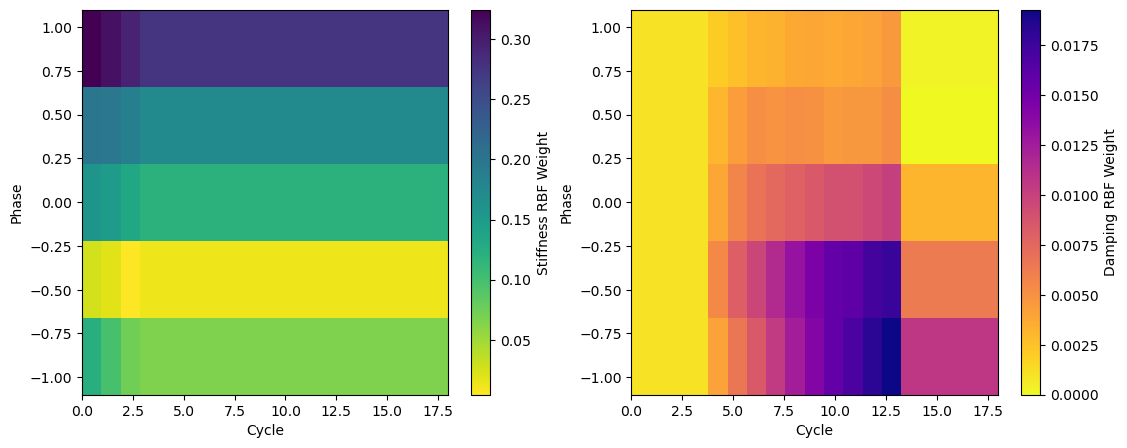

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

# --- RBF 히트맵 ---
im1 = axes[0].imshow(W.T, aspect='auto', cmap='viridis_r',
                     extent=[cycle_nums[0], cycle_nums[-1], phase_labels[0], phase_labels[-1]],
                     origin='lower')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Phase')
# axes[0].set_title('RBF (Stiffness) Heatmap')
fig.colorbar(im1, ax=axes[0], label='Stiffness RBF Weight')

# --- Damping 히트맵 ---
im2 = axes[1].imshow(D.T, aspect='auto', cmap='plasma_r',
                     extent=[cycle_nums[0], cycle_nums[-1], phase_labels[0], phase_labels[-1]],
                     origin='lower')
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Phase')
# axes[1].set_title('Damping Heatmap')
fig.colorbar(im2, ax=axes[1], label='Damping RBF Weight')

# plt.tight_layout()
plt.show()


In [ ]:
group = 'Datas' if 'Datas' in group_channel_map else list(group_channel_map.keys())[0]
print(f"\n▶ Using group: {group}")

sample_rate  = 50
cut_sec      = 15
num_cycles   = 2
base_color   = 'C0'
lw_overlay   = 2    # Overlay plot 굵기

traj   = tdms[group]['Trajectory'][:]
ref_x  = tdms[group]['Reference Position X'][:]
ref_y  = tdms[group]['Reference Position Y'][:]
act_x  = tdms[group]['Measured Position X'][:]
act_y  = tdms[group]['Measured Position Y'][:]
time   = np.arange(len(traj)) / sample_rate

traj_bin = (traj > 0.5).astype(int)
phase_ref_deg = np.degrees((np.arctan2(ref_y, ref_x) + 2*np.pi) % (2*np.pi))
phase_act_deg = np.degrees((np.arctan2(act_y, act_x) + 2*np.pi) % (2*np.pi))
phase_ref_deg = ((phase_ref_deg + 180) % 360) - 180
phase_act_deg = ((phase_act_deg + 180) % 360) - 180

cut_len = int(cut_sec * sample_rate)
rising_idx = np.where((traj_bin[:-1] == 0) & (traj_bin[1:] == 1))[0] + 1

segments_act, segments_ref = [], []
segments_refX, segments_refY = [], []
segments_actX, segments_actY = [], []
segments_err = []

# for s in rising_idx[-num_cycles:]:
#     if s + cut_len <= len(traj_bin):
#         # phase trajectory
#         seg_act = phase_act_deg[s:s+cut_len].copy()
#         seg_ref = phase_ref_deg[s:s+cut_len].copy()
#         segments_act.append(seg_act)
#         segments_ref.append(seg_ref)
#         # Cartesian trajectory
#         segments_refX.append(ref_x[s:s+cut_len].copy())
#         segments_refY.append(ref_y[s:s+cut_len].copy())
#         segments_actX.append(act_x[s:s+cut_len].copy())
#         segments_actY.append(act_y[s:s+cut_len].copy())
#         # error
#         seg_err = (seg_ref - seg_act)
#         seg_err = (seg_err + 180) % 360 - 180  # -180~180 wrap
#         seg_err_scaled = seg_err / -90 * 100
#         segments_err.append(seg_err_scaled)

selected_indices = [36,37]  # 원하는 사이클 인덱스 (0부터 시작)

for i in selected_indices:
    if i < len(rising_idx):
        s = rising_idx[i]
        if s + cut_len <= len(traj_bin):
            # phase trajectory
            seg_act = phase_act_deg[s:s+cut_len].copy()
            seg_ref = phase_ref_deg[s:s+cut_len].copy()
            segments_act.append(seg_act)
            segments_ref.append(seg_ref)
            # Cartesian trajectory
            segments_refX.append(ref_x[s:s+cut_len].copy())
            segments_refY.append(ref_y[s:s+cut_len].copy())
            segments_actX.append(act_x[s:s+cut_len].copy())
            segments_actY.append(act_y[s:s+cut_len].copy())
            # error
            seg_err = (seg_ref - seg_act)
            seg_err = (seg_err + 180) % 360 - 180  # -180~180 wrap
            seg_err_scaled = seg_err / -90 * 100
            segments_err.append(seg_err_scaled)



if len(segments_act) == 0:
    print("추출된 cycle이 없습니다.")
else:
    segments_act = np.vstack(segments_act)
    segments_ref = np.vstack(segments_ref)
    segments_refX = np.vstack(segments_refX)
    segments_refY = np.vstack(segments_refY)
    segments_actX = np.vstack(segments_actX)
    segments_actY = np.vstack(segments_actY)
    segments_err = np.vstack(segments_err)
    t_short = np.arange(cut_len) / sample_rate

    # === Phase Overlay Plot ===
    plt.figure(figsize=(10,5))
    plt.plot(t_short, segments_ref[-1], color='black', linestyle='--', linewidth=lw_overlay, label='Reference Trajectory')
    for idx2, seg in enumerate(segments_act):
        alpha = 1
        lw = 2
        if idx2 == len(segments_act)-1:
            label = 'Measured Trajectory'
        else:
            label = None
        plt.plot(t_short, seg, color=base_color, alpha=alpha, lw=lw_overlay, label=label)
    plt.xlabel('Time [s]')
    plt.ylabel('Phase [deg]')
    # plt.title(f'Overlay: Last {num_cycles} cycles (Each {cut_sec}s)')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.show()

    # === Cartesian Overlay Plot ===
    plt.figure(figsize=(7,7))
    plt.plot(segments_refX[-1], segments_refY[-1], 'k--', lw=lw_overlay, label='Reference Path')
    for idx2, seg in enumerate(segments_act):
        alpha = 1
        lw = 2
        if idx2 == len(segments_act)-1:
            label = 'Measured Path'
        else:
            label = None
        plt.plot(segments_actX[idx2], segments_actY[idx2], color=base_color, alpha=alpha, lw=lw_overlay, label=label if idx2==len(segments_actX)-1 else None)
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(f'Cartesian Overlay: Last {num_cycles} cycles')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    # === Error Mean ± STD Plot ===
    mean_err = np.mean(segments_err, axis=0)
    std_err  = np.std(segments_err, axis=0)
    plt.figure(figsize=(10,5))
    plt.plot(t_short, mean_err, color='C2', lw=2, label='Error Mean')
    plt.fill_between(t_short, mean_err-std_err, mean_err+std_err, color='C2', alpha=0.2, label='±1 STD')
    plt.axhline(0, color='k', linestyle='--', lw=1)
    plt.xlabel('Time [s]')
    plt.ylabel('Phase Error [%]')
    # plt.title(f'Phase Error (Mean ± STD), Last {num_cycles} cycles, Each {cut_sec}s')
    plt.legend()
    plt.grid(True)
    plt.show()


▶ Using group: Datas
추출된 cycle이 없습니다.


In [ ]:
print("rising_idx (초 단위):", rising_idx[:2] / sample_rate)
print("총 상승점 개수:", len(rising_idx))
print("segments_act 개수:", len(segments_act))


rising_idx (초 단위): [147.58 176.68]
총 상승점 개수: 28
segments_act 개수: 0
